# EnKF Experiments

## Imports

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import shapiro, kruskal
import seaborn as sns
import sys

%matplotlib inline

In [16]:
sys.path.append('../../stationsim/')

In [17]:
from ensemble_kalman_filter import EnsembleKalmanFilter
from stationsim_gcs_model import Model

## Functions

In [18]:
def tidy_dataframe(df, independent_col: str, dependent_cols: list):
    output = list()
    
    for i, row in df.iterrows():
        for col in dependent_cols:
            d = {independent_col: row[independent_col],
                 'variable':  col,
                 'value': row[col]}
            output.append(d)
    
    output = pd.DataFrame(output)
    return output

## Data paths

In [19]:
data_dir = './results/data/'
toy_model_baseline_dir = data_dir + 'toy_model_baseline/'
toy_model_1_dir = data_dir + 'toy_model_exp_1/'

In [20]:
fig_dir = './results/figures/toy_model/'

In [21]:
model_dir = './results/models/'

## Toy model

### Baseline

#### Read data

In [8]:
with open(model_dir + 'baseline.pkl', 'rb') as f:
    baseline_filter = pickle.load(f)

baseline_results = pd.DataFrame(baseline_filter.forecast_error)
baseline_results.head()

,time,forecast
0,0,0.000000
1,1,0.002348
2,2,0.002345
3,3,0.002342
4,4,0.002339


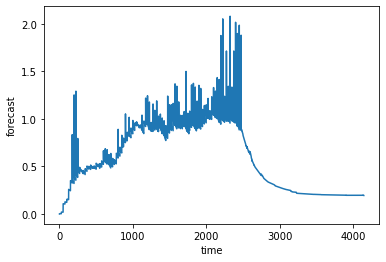

In [9]:
plt.figure()
sns.lineplot(x='time', y='forecast', data=baseline_results)
plt.savefig(fig_dir + 'baseline_errors_10.pdf')
plt.show()

In [10]:
collisions = pd.read_csv(toy_model_baseline_dir + 'model_collisions.csv')
collisions.head()

,Unnamed: 0,collisions,population_size
0,0,0,5
1,1,9,5
2,2,0,5
3,3,4,5
4,4,1,5


In [11]:
if 'Unnamed: 0' in collisions.columns:
    collisions = collisions.drop('Unnamed: 0', axis=1)

In [12]:
collisions.head()

,collisions,population_size
0,0,5
1,9,5
2,0,5
3,4,5
4,1,5


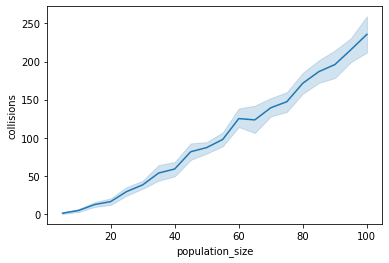

In [13]:
plt.figure()
sns.lineplot(x='population_size', y='collisions', data=collisions)
plt.savefig(fig_dir + 'baseline_collisions.pdf')
plt.show()

### Experiment 1

#### Read data

In [14]:
results = pd.read_csv(toy_model_1_dir + 'p100/metrics.csv')
results.head()

,time,forecast,obs,analysis,vanilla
0,0,0.000000,1.090119,0.000000,0.000000
1,20,0.028441,1.206344,0.002213,0.036007
2,40,0.002347,1.040418,0.005282,0.055467
3,60,0.070811,1.073856,0.009031,0.090809
4,80,0.057292,1.082838,0.008435,0.138038


In [15]:
results.shape

(2079, 5)

#### Tidy up data

In [16]:
error_types = ['forecast', 'obs', 'analysis', 'baseline']

In [17]:
tidy_df = tidy_dataframe(results, 'time', error_types)
tidy_df.head()

,time,variable,value
0,0.0,forecast,0.000000
1,0.0,obs,1.090119
2,0.0,analysis,0.000000
3,0.0,vanilla,0.000000
4,20.0,forecast,0.028441


#### Plot results

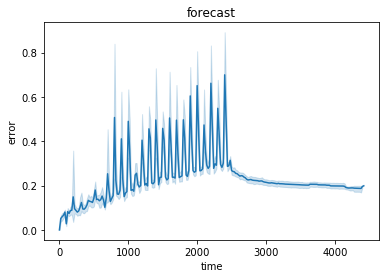

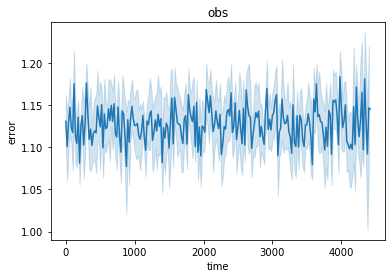

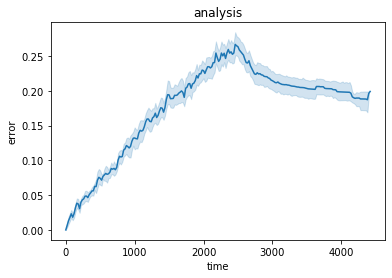

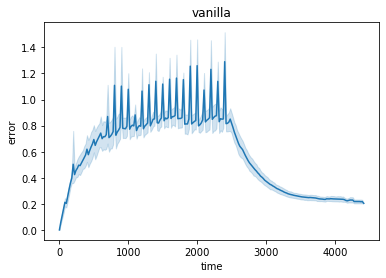

In [18]:
for error_type in error_types:
    df = tidy_df.loc[tidy_df['variable']==error_type, :]
    plt.figure()
    sns.lineplot(x='time', y='value', data=df)
    plt.ylabel('error')
    plt.title(error_type)
    plt.savefig(fig_dir + f'exp_1_{error_type}.pdf')
    plt.show()

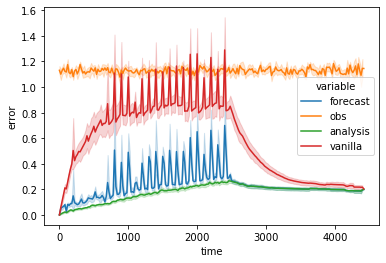

In [19]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_1.pdf')
plt.show()

In [20]:
reduced_tidy_df = tidy_df.loc[(tidy_df['variable']=='baseline') | (tidy_df['variable']=='analysis'), :]

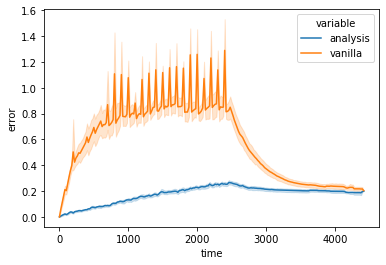

In [21]:
plt.figure()
sns.lineplot(x='time', y='value', hue='variable', data=reduced_tidy_df)
plt.ylabel('error')
plt.savefig(fig_dir + 'exp_1_reduced.pdf')
plt.show()

### Experiment 2

In [22]:
results_path = './results/map_data.csv'
results = pd.read_csv(results_path)

In [23]:
results.head()

,time,forecast,obs,analysis,assimilation_period,ensemble_size,population_size,std
0,0,0.000000,0.679619,0.000000,2,2,10,0.5
1,2,0.235169,0.541200,0.004255,2,2,10,0.5
2,4,0.004244,0.567634,0.044575,2,2,10,0.5
3,6,0.044461,0.600967,0.038708,2,2,10,0.5
4,8,0.038608,0.521710,0.039674,2,2,10,0.5


#### Variation w.r.t ensemble size

In [24]:
condition = (results['assimilation_period']==20) & (results['population_size']==20) & (results['std']==1.0)
tdf = results.loc[condition, :]

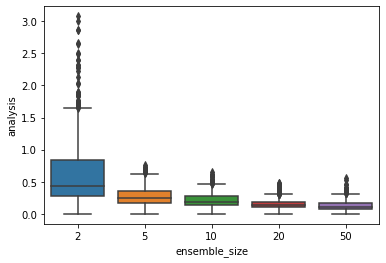

In [25]:
plt.figure()
sns.boxplot(x='ensemble_size', y='analysis', data=tdf)
plt.savefig(fig_dir + 'exp_2_es_box.pdf')
plt.show()

Test each collection of samples for normality using the Shapiro-Wilk test:

20


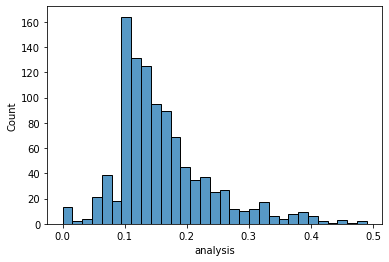

(0.9038395285606384, 5.912333018775546e-25)
2


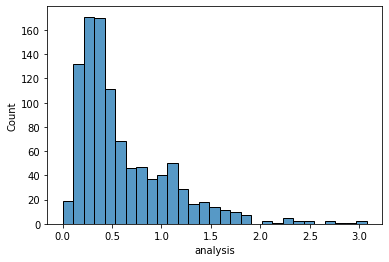

(0.8404701352119446, 1.0803110937729285e-30)
5


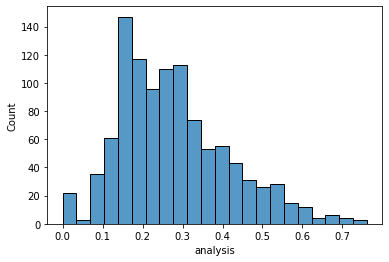

(0.9599201679229736, 1.9043403678266026e-16)
50


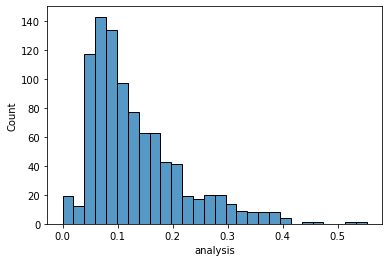

(0.8874620199203491, 1.3849063325761244e-25)
10


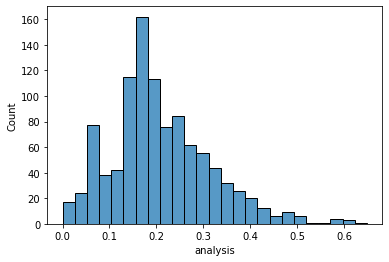

(0.9642613530158997, 3.3288697641372647e-15)


In [26]:
for es in tdf['ensemble_size'].unique():
    print(es)
    d = tdf.loc[tdf['ensemble_size']==es, :]
    plt.figure()
    sns.histplot(x='analysis', data=d)
    plt.show()
    t = shapiro(d['analysis'])
    print(t)

In each case, we have sufficient evidence to reject the null hypothesis that the samples are normally distributed.
We then go on to apply the Kruskal-Wallis test to see if there is a significant difference in the median of the samples:

In [30]:
x = [tdf.loc[tdf['ensemble_size']==es, 'analysis'] for es in sorted(tdf['ensemble_size'].unique())]
t = kruskal(*x)
print(t)

KruskalResult(statistic=2016.3020550994493, pvalue=0.0)


The significant p-value here suggests that there is a significant difference in the medians of the samples.

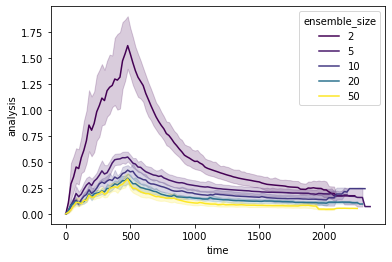

In [12]:
plt.figure()
sns.lineplot(x='time', y='analysis', hue='ensemble_size',
             data=tdf, palette='viridis')
plt.savefig(fig_dir + 'exp_2_es_line.pdf')
plt.show()

#### Variation w.r.t assimilation period

In [31]:
condition = (results['ensemble_size']==20) & (results['population_size']==20) & (results['std']==1.0)
tdf = results.loc[condition, :]

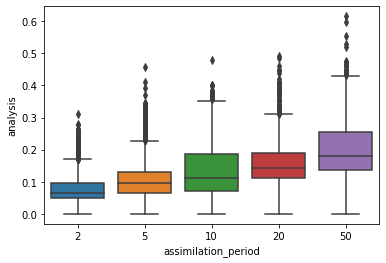

In [32]:
plt.figure()
sns.boxplot(x='assimilation_period', y='analysis', data=tdf)
plt.savefig(fig_dir + 'exp_2_ap_box.pdf')
plt.show()

Test each collection of samples for normality using the Shapiro-Wilk test:

20


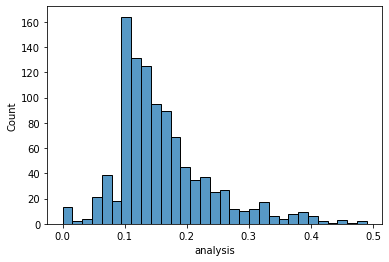

(0.9038395285606384, 5.912333018775546e-25)
5


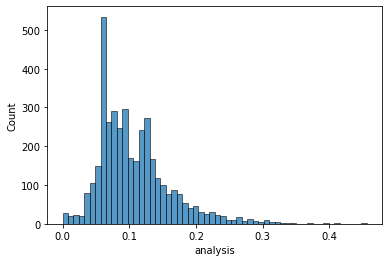

(0.9140896201133728, 2.061310041021806e-42)
50


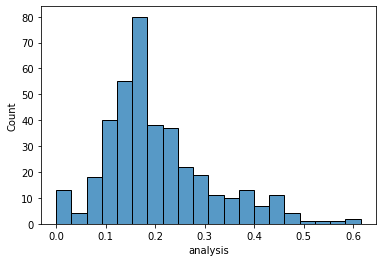

(0.9410615563392639, 2.8738390139837477e-11)
10


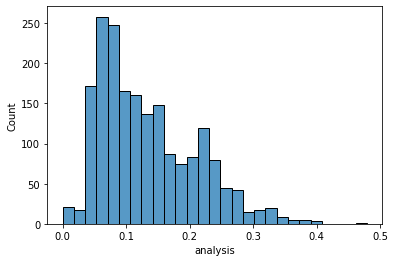

(0.934300422668457, 2.342906295891711e-28)
2


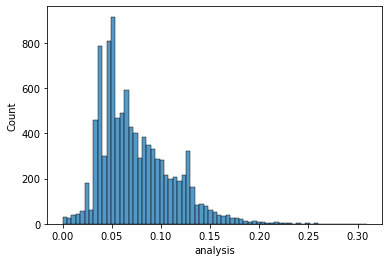

(0.9357618689537048, 0.0)


/home/keiran/miniconda3/envs/dust/lib/python3.8/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [36]:
for ap in tdf['assimilation_period'].unique():
    print(ap)
    d = tdf.loc[tdf['assimilation_period']==ap, :]
    plt.figure()
    sns.histplot(x='analysis', data=d)
    plt.show()
    t = shapiro(d['analysis'])
    print(t)

In each case, we have sufficient evidence to reject the null hypothesis that the samples are normally distributed.
We then go on to apply the Kruskal-Wallis test to see if there is a significant difference in the median of the samples:

In [37]:
x = [tdf.loc[tdf['assimilation_period']==ap, 'analysis'] for ap in sorted(tdf['assimilation_period'].unique())]
t = kruskal(*x)
print(t)

KruskalResult(statistic=3682.5568240845028, pvalue=0.0)


The significant p-value here suggests that there is a significant difference in the medians of the samples.

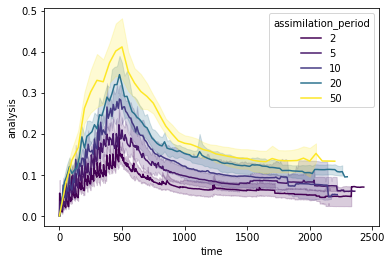

In [15]:
plt.figure()
sns.lineplot(x='time', y='analysis', hue='assimilation_period',
             data=tdf, palette='viridis')
plt.savefig(fig_dir + 'exp_2_ap_line.pdf')
plt.show()

#### Variation w.r.t observation error standard_deviation

In [39]:
condition = (results['ensemble_size']==20) & (results['population_size']==20) & (results['assimilation_period']==20)
tdf = results.loc[condition, :]

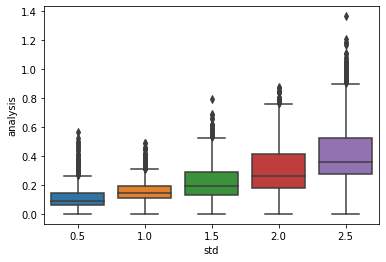

In [40]:
plt.figure()
sns.boxplot(x='std', y='analysis', data=tdf)
plt.savefig(fig_dir + 'exp_2_std_box.pdf')
plt.show()

Test each collection of samples for normality using the Shapiro-Wilk test:

1.0


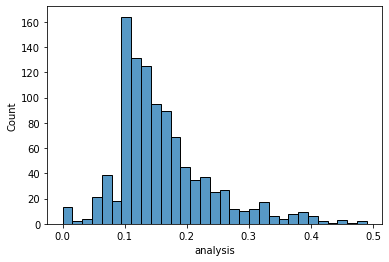

(0.9038395285606384, 5.912333018775546e-25)
2.0


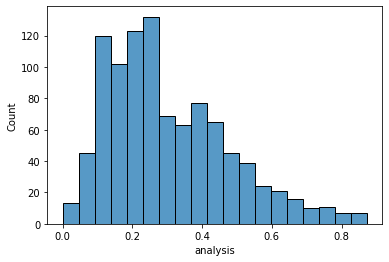

(0.944238007068634, 7.645893548660003e-19)
2.5


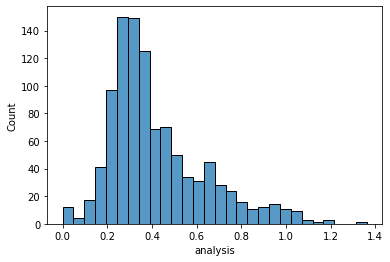

(0.9124339818954468, 7.245972193241778e-24)
1.5


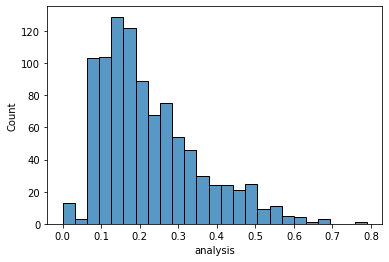

(0.926642656326294, 2.7599220411129886e-21)
0.5


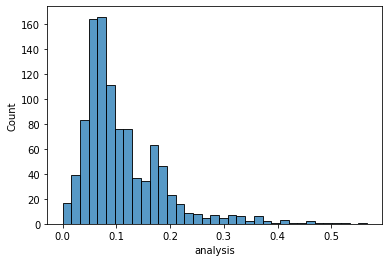

(0.8259925246238708, 7.054049322978008e-32)


In [41]:
for std in tdf['std'].unique():
    print(std)
    d = tdf.loc[tdf['std']==std, :]
    plt.figure()
    sns.histplot(x='analysis', data=d)
    plt.show()
    t = shapiro(d['analysis'])
    print(t)

In each case, we have sufficient evidence to reject the null hypothesis that the samples are normally distributed.
We then go on to apply the Kruskal-Wallis test to see if there is a significant difference in the median of the samples:

In [42]:
x = [tdf.loc[tdf['std']==std, 'analysis'] for std in sorted(tdf['std'].unique())]
t = kruskal(*x)
print(t)

KruskalResult(statistic=2143.285077600999, pvalue=0.0)


The significant p-value here suggests that there is a significant difference in the medians of the samples.

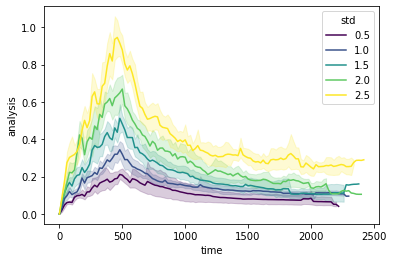

In [18]:
plt.figure()
sns.lineplot(x='time', y='analysis', hue='std',
             data=tdf, palette='viridis')
plt.savefig(fig_dir + 'exp_2_std_line.pdf')
plt.show()

#### Variation w.r.t population_size

In [19]:
condition = (results['ensemble_size']==20) & (results['std']==1.0) & (results['assimilation_period']==20)
tdf = results.loc[condition, :]

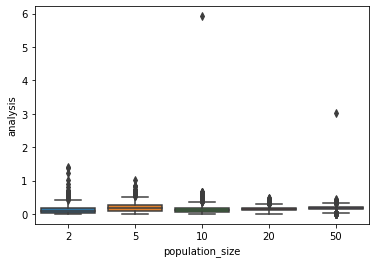

In [20]:
plt.figure()
sns.boxplot(x='population_size', y='analysis', data=tdf)
plt.savefig(fig_dir + 'exp_2_ps_box.pdf')
plt.show()

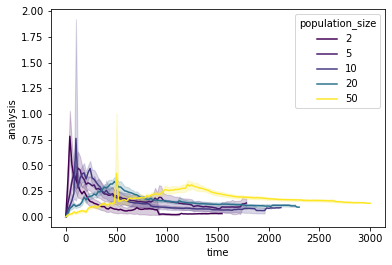

In [21]:
plt.figure()
sns.lineplot(x='time', y='analysis', hue='population_size',
             data=tdf, palette='viridis')
plt.savefig(fig_dir + 'exp_2_ps_line.pdf')
plt.show()

#### Making averages for each combination

In [22]:
results_path = './results/map_data.csv'
results = pd.read_csv(results_path)

In [23]:
len(results.loc[results['assimilation_period']==2, :])

1078338

In [24]:
len(results.loc[results['assimilation_period']==20, :])

108614

In [25]:
results.head()

,time,forecast,obs,analysis,assimilation_period,ensemble_size,population_size,std
0,0,0.000000,0.679619,0.000000,2,2,10,0.5
1,2,0.235169,0.541200,0.004255,2,2,10,0.5
2,4,0.004244,0.567634,0.044575,2,2,10,0.5
3,6,0.044461,0.600967,0.038708,2,2,10,0.5
4,8,0.038608,0.521710,0.039674,2,2,10,0.5


In [26]:
ensemble_sizes = results['ensemble_size'].unique()
assimilation_periods = results['assimilation_period'].unique()
pop_sizes = results['population_size'].unique()
stds = results['std'].unique()

In [27]:
averages = list()

for es in ensemble_sizes:
    for ap in assimilation_periods:
        for ps in pop_sizes:
            for std in stds:
                tdf = results.loc[(results['ensemble_size']==es) & (results['assimilation_period']==ap) & (results['population_size']==ps) & (results['std']==std), :]
                
                d = {'analysis': tdf['analysis'].mean(),
                     'ensemble_size': es,
                     'assimilation_period': ap,
                     'population_size': ps,
                     'std': std}
                averages.append(d)

In [28]:
averages = pd.DataFrame(averages)
averages.head()

,analysis,ensemble_size,assimilation_period,population_size,std
0,0.346123,2,2,10,0.5
1,0.554764,2,2,10,2.0
2,0.318773,2,2,10,1.0
3,0.426060,2,2,10,1.5
4,0.610636,2,2,10,2.5


#### Contour plots

In [29]:
def make_contourmap(averages, free_var_1='ensemble_size', free_var_2='std',
                 fixed_var_1='assimilation_period', fixed_var_2='population_size',
                 val_1=20, val_2=20):
    tdf = averages.loc[(averages[fixed_var_1]==val_1) & (averages[fixed_var_2]==val_2), :]
    free_1 = sorted(tdf[free_var_1].unique())
    free_2 = sorted(tdf[free_var_2].unique())
    
    z = list()
    for f1 in free_1:
        row = list()
        for f2 in free_2:
            df = tdf.loc[(tdf[free_var_1]==f1) & (tdf[free_var_2]==f2), :]
            row.append(df['analysis'].unique()[0])
        z.append(row)
    
    z = np.array(z).T
    
    f = plt.figure()
    plt.contourf(z, 10)
    plt.xticks(np.arange(0, len(free_1), 1), free_1)
    plt.yticks(np.arange(0, len(free_1), 1), free_2)
    plt.xlabel(free_var_1)
    plt.ylabel(free_var_2)
    plt.colorbar()
    return f

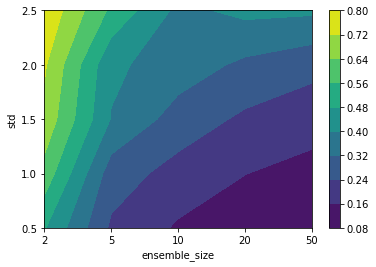

In [30]:
f = make_contourmap(averages)
f.savefig(fig_dir + 'exp_2_contour_es_std.pdf')

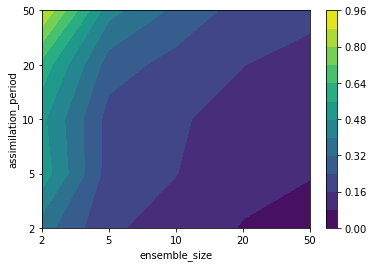

In [31]:
f = make_contourmap(averages, free_var_1='ensemble_size', free_var_2='assimilation_period',
                    fixed_var_1='population_size', fixed_var_2='std', val_1=20, val_2=1.0)
f.savefig(fig_dir + 'exp_2_contour_es_ap.pdf')

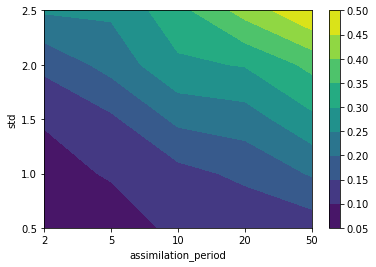

In [32]:
f = make_contourmap(averages, free_var_1='assimilation_period', free_var_2='std',
                    fixed_var_1='ensemble_size', fixed_var_2='population_size', val_1=20, val_2=20)
f.savefig(fig_dir + 'exp_2_contour_ap_std.pdf')